# PCA and Logistic Regression

## PCA

Necessary imports.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gzip

Load the given data by the provided functions.

In [6]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path, 'rb') as f:
        # Skip the header since we already know the format
        f.read(16)

        # Read the pixel data
        pixel_data = np.frombuffer(f.read(), dtype=np.uint8)

    # Flatten the normalized pixels
    flattened_pixels = pixel_data.reshape(-1, 28 * 28) / 255.0

    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

images = read_pixels("train-images-idx3-ubyte.gz")
labels = read_labels("train-labels-idx1-ubyte.gz")

Apply PCA on the dataset to obtain the principal components. Report the proportion of variance explained (PVE) for the first 10 principal components.

In [8]:
def pca(data, num_components=10):

    mean_data = np.mean(data, axis=0)

    centered_data = data - mean_data

    cov_matrix = np.cov(centered_data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvalues, eigenvectors from high to low
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the wanted eigenvectors, from the start of the sorted list
    selected_eigenvectors = eigenvectors[:, :num_components]

    # PVE calculation for each component separately
    total_variance = np.sum(eigenvalues)
    explained_variances = np.real(eigenvalues) / total_variance  # Take only the real part

    # PVE calculation cumulatively for the first 10 components
    cumulative_explained_variances = np.cumsum(explained_variances[:num_components])

    return eigenvectors, explained_variances, cumulative_explained_variances

# Eigenvectors will be used in Q1.3
eigenvectors, pve_per_component, cumulative_pve = pca(images, num_components=10)

# Print the real parts of the result
print("\nPVE for each component separately:")
print(np.real(pve_per_component[:10]))

print("\nPVE for the first 10 principal components cumulatively:")
print(np.real(cumulative_pve))



PVE for each component separately:
[0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001]

PVE for the first 10 principal components cumulatively:
[0.09704664 0.16800588 0.22969677 0.28359097 0.33227894 0.37540125
 0.40812055 0.4369595  0.4645798  0.4881498 ]


Q1.2 Report how many components explain 70% of the data.

In [10]:
def components_for_variance(data, target_variance=0.7):

    mean_data = np.mean(data, axis=0)

    centered_data = data - mean_data

    cov_matrix = np.cov(centered_data, rowvar=False)

    eigenvalues, _ = np.linalg.eig(cov_matrix)

    # Sort eigenvalues from high to low
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]

    # Calculate the PVE for each component
    explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

    # Find the number of components needed
    num_components = np.argmax(explained_variance >= target_variance) + 1

    return num_components

# Function call
num_components_70 = components_for_variance(images, target_variance=0.7)

# Print the result
print("\nNumber of components needed to explain at least 70% of the variance:", num_components_70)


Number of components needed to explain at least 70% of the variance: 26


Reshape and display the first 10 principal components.


Reshape and display the first 10 principal components.



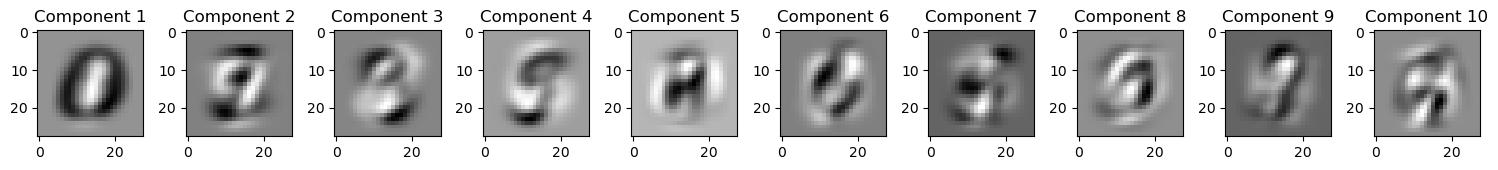

In [12]:
def visual_principal_comp(components, num_components=10):
    fig, axes = plt.subplots(1, num_components, figsize=(15, 3))

    for i in range(num_components):
        # Reshape to 28x28 matrix
        component_matrix = components[:, i].reshape(28, 28)

        real_component = np.real(component_matrix)

        # Apply min-max scaling
        scaled_component = (real_component - np.min(real_component)) / (np.max(real_component) - np.min(real_component))

        # Display the image with equal aspect ratio
        axes[i].imshow(scaled_component, cmap='gray', aspect='equal')
        axes[i].set_title(f'Component {i+1}')

    plt.tight_layout()
    plt.show()

# Using the eigenvectors that are calculated in Question 1.1
# Select the first 10 principal components
first_10_components = eigenvectors[:, :10]

# Visualize the first 10 principal components
print("\nReshape and display the first 10 principal components.\n")
visual_principal_comp(first_10_components, num_components=10)


Project the first 100 images onto the first 2 principal components.


Project the first 100 images onto the first 2 principal components.



C:\Users\lenovo\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\lenovo\anaconda3\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


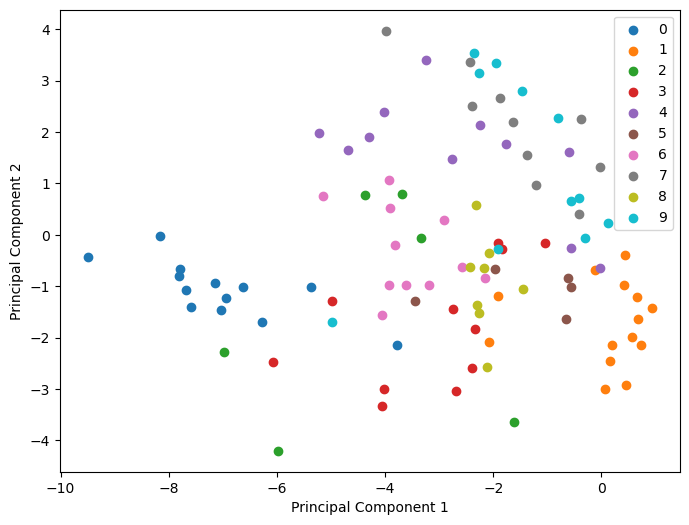

In [14]:
def project_and_visualize(images, labels, components, num_points=100):

    # Select num_points images and labels
    selected_images = images[:num_points, :]
    selected_labels = labels[:num_points]

    # Project the selected images onto the first 2 principal components
    projected_data = np.dot(selected_images, components[:, :2])

    # Plot data
    color_map = plt.get_cmap('tab10')
    plt.figure(figsize=(8, 6))
    for label in range(10):
        indices = (selected_labels == label)
        plt.scatter(projected_data[indices, 0], projected_data[indices, 1], label=f'{label}', color=color_map(label))

    plt.legend()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.show()

# Select the first 100 images and their labels
first_100_images = images[:100, :]
first_100_labels = labels[:100]

# Apply the function and print the results
print("\nProject the first 100 images onto the first 2 principal components.\n")
project_and_visualize(first_100_images, first_100_labels, first_10_components[:, :2])


Reconstruct an original digit image using different numbers of principal components.


Reconstruct an original digit image using different numbers of principal components.



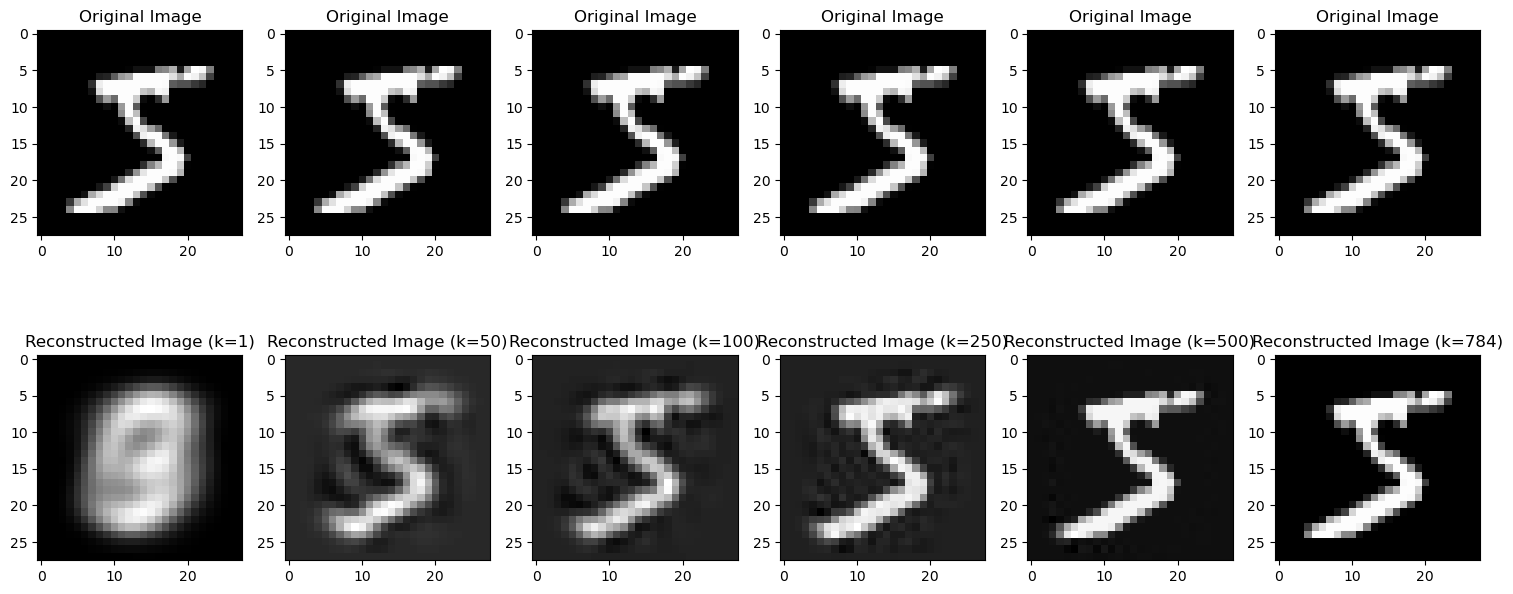

In [16]:
def reconstruct_image(image, mean, components, k):
    flattened_image = image.flatten()

    # Project onto the first k components
    projection = np.dot(flattened_image - mean, components[:, :k])

    # Reconstruct the image, add the mean
    reconstructed_image = np.dot(projection, components[:, :k].T) + mean

    reconstructed_image = np.real(reconstructed_image)

    # Reshape the image to 28x28
    reconstructed_image = reconstructed_image.reshape(28, 28)

    return reconstructed_image

mean_image = np.mean(images, axis=0)
first_image = images[0, :]

k_values = [1, 50, 100, 250, 500, 784]

print("\nReconstruct an original digit image using different numbers of principal components.\n")

# Plot the original and reconstructed images for each k
plt.figure(figsize=(15, 7))
for i, k in enumerate(k_values, 1):
    reconstructed_image = reconstruct_image(first_image, mean_image, eigenvectors, k)

    # Original image
    plt.subplot(2, 6, i)
    plt.imshow(first_image.reshape(28, 28), cmap='gray')
    plt.title(f'Original Image')

    # Reconstructed image
    plt.subplot(2, 6, i + len(k_values))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstructed Image (k={k})')

plt.tight_layout()
plt.show()

## Logistic Regression

Start with the completed implementations of given functions.

In [19]:
# One-hot encoding of the labels
def one_hot_encoding(label_data):
    unique_labels = np.unique(label_data)
    encoded_labels = np.zeros((len(label_data), len(unique_labels)))

    for i, label in enumerate(label_data):
        encoded_labels[i, label] = 1

    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path, 'rb') as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28 * 28)  # Flatten the normalized pixels
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path, 'rb') as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("train-images-idx3-ubyte.gz")
    y_train = read_labels("train-labels-idx1-ubyte.gz")
    X_test = read_pixels("t10k-images-idx3-ubyte.gz")
    y_test = read_labels("t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = read_dataset()

Now, create the required validation set from the training set.

In [21]:
# Create the validation set from the train set
num_validation_samples = 10000
X_validation = X_train[:num_validation_samples, :]
y_validation = y_train[:num_validation_samples, :]

# Remove the selected validation set the training set
X_train = X_train[num_validation_samples:, :]
y_train = y_train[num_validation_samples:, :]

# Display the shapes of the final sets
print("\nFinal set shapes after the split\n")
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_validation.shape)
print("Test set shape:", X_test.shape)


Final set shapes after the split

Training set shape: (50000, 784)
Validation set shape: (10000, 784)
Test set shape: (10000, 784)


Train the default model. Display the test accuracy and confusion
matrix for that case.


Train the default model. Display the test accuracy and confusion matrix for that case.

Test Accuracy: 0.9064

Confusion Matrix:
954 0 5 2 1 5 6 4 2 1
0 1104 4 4 0 1 4 2 15 1
5 13 903 27 5 6 12 9 46 6
6 2 20 894 1 37 4 9 27 10
3 2 7 2 898 0 14 4 10 42
11 3 6 45 13 747 14 8 35 10
15 3 9 2 14 19 890 2 4 0
2 10 21 7 8 5 0 925 4 46
6 8 10 29 8 32 13 5 852 11
8 6 1 10 38 7 1 31 10 897


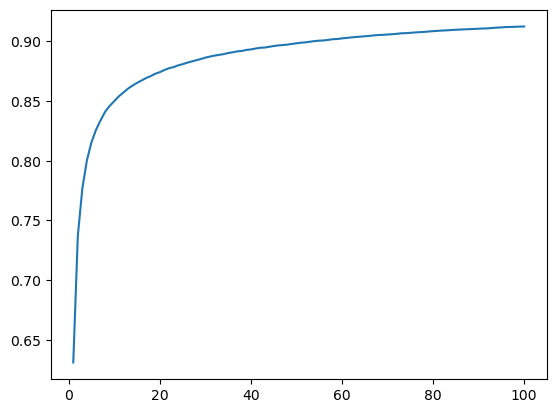

In [23]:
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = [[0] * num_classes for _ in range(num_classes)]

    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1

    return matrix

def display_confusion_matrix(matrix):
    for row in matrix:
        print(" ".join(map(str, row)))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def initialize_weights(input_size, output_size):
    np.random.seed(0)
    return np.random.normal(0, 1, (input_size, output_size))

def predict(X, weights):
    return softmax(np.dot(X, weights))

def cross_entropy_loss(y_true, y_pred, weights, l2_reg):
    m = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m
    reg_term = (l2_reg / (2 * m)) * np.sum(weights**2)
    return loss + reg_term

def gradient_descent(X, y, weights, learning_rate, l2_reg):
    m = len(y)
    y_pred = predict(X, weights)
    error = y_pred - y
    # Sum instead of mean in gradient descent
    gradient = np.dot(X.T, error) + (l2_reg / m) * weights
    weights -= learning_rate * gradient
    return weights

def train_logistic_regression(X_train, y_train, X_val, y_val, learning_rate, l2_reg, epochs, batch_size, weight_init):
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]

    if weight_init == 'zero':
        weights = np.zeros((input_size, output_size))
    elif weight_init == 'uniform':
        weights = np.random.uniform(-1, 1, (input_size, output_size))
    elif weight_init == 'normal':
        weights = initialize_weights(input_size, output_size)

    m_train = len(y_train)
    train_accuracies = []

    for epoch in range(epochs):
        for batch_start in range(0, m_train, batch_size):
            batch_end = min(batch_start + batch_size, m_train)
            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            weights = gradient_descent(X_batch, y_batch, weights, learning_rate, l2_reg)

        # Calculate training accuracy
        y_train_pred = predict(X_train, weights)
        train_predictions = np.argmax(y_train_pred, axis=1)
        train_labels = np.argmax(y_train, axis=1)
        train_accuracy = np.sum(train_predictions == train_labels) / len(train_labels)
        train_accuracies.append(train_accuracy)

    # Plot the training accuracy over epochs
    plt.plot(range(1, epochs + 1), train_accuracies, label=f'Batch Size: {batch_size}, Weight Init: {weight_init}, LR: {learning_rate}, λ: {l2_reg}')

    return weights

print("Train the default model. Display the test accuracy and confusion matrix for that case.\n")
# Train the logistic regression model
trained_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, 5e-4, 1e-4, 100, 200, "normal")

# Evaluate the model on the test set
y_test_pred = predict(X_test, trained_weights)
test_predictions = np.argmax(y_test_pred, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)

print(f"Test Accuracy: {test_accuracy:.4f}")

num_classes = y_train.shape[1] if y_train is not None else y_test.shape[1]

# Create and display the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions, num_classes=num_classes)
print("\nConfusion Matrix:")
display_confusion_matrix(conf_matrix)

Do separate experiments on the hyperparameters given, one at a time.


Do separate experiments on the hyperparameters given, one at a time.



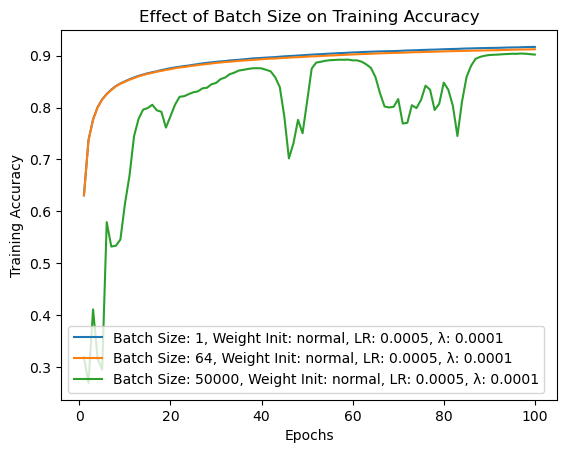

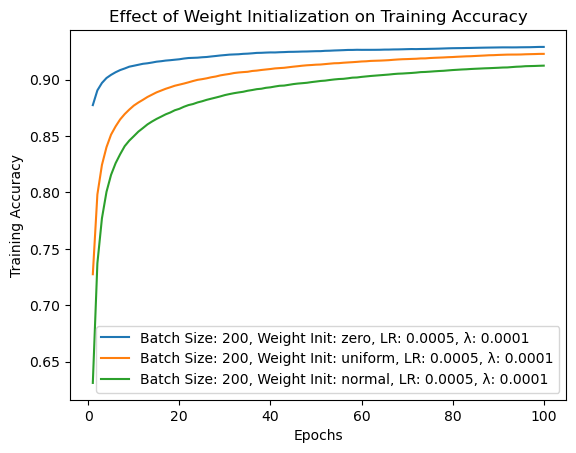

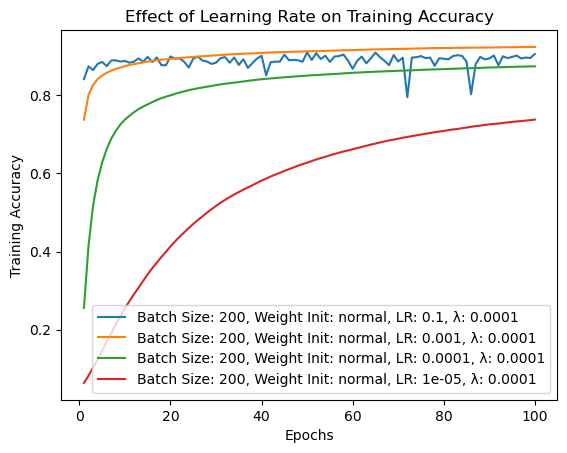

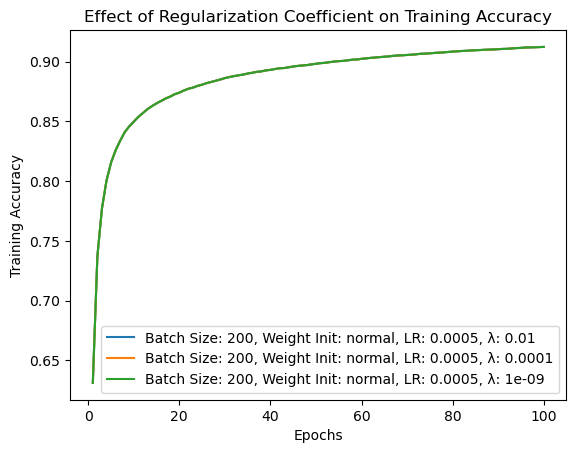

In [25]:
print("\nDo separate experiments on the hyperparameters given, one at a time.\n")

# Experiment 1: Varying Batch Size
batch_sizes = [1, 64, 50000]
best_val_accuracy_batch = 0
best_batch_size = None

for batch_size in batch_sizes:
    trained_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=5e-4, l2_reg=1e-4, epochs=100, batch_size=batch_size, weight_init='normal')

    # Evaluate on validation set
    y_val_pred = predict(X_validation, trained_weights)
    val_predictions = np.argmax(y_val_pred, axis=1)
    val_labels = np.argmax(y_validation, axis=1)
    val_accuracy = np.sum(val_predictions == val_labels) / len(val_labels)

    if val_accuracy > best_val_accuracy_batch:
        best_val_accuracy_batch = val_accuracy
        best_batch_size = batch_size

plt.title('Effect of Batch Size on Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Experiment 2: Varying Weight Initialization Technique
weight_inits = ['zero', 'uniform', 'normal']
best_val_accuracy_init = 0
best_weight_init = None

for weight_init in weight_inits:
    trained_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=5e-4, l2_reg=1e-4, epochs=100, batch_size=200, weight_init=weight_init)

    # Evaluate on validation set
    y_val_pred = predict(X_validation, trained_weights)
    val_predictions = np.argmax(y_val_pred, axis=1)
    val_labels = np.argmax(y_validation, axis=1)
    val_accuracy = np.sum(val_predictions == val_labels) / len(val_labels)

    if val_accuracy > best_val_accuracy_init:
        best_val_accuracy_init = val_accuracy
        best_weight_init = weight_init

plt.title('Effect of Weight Initialization on Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Experiment 3: Varying Learning Rate
learning_rates = [0.1, 1e-3, 1e-4, 1e-5]
best_val_accuracy_lr = 0
best_learning_rate = None

for lr in learning_rates:
    trained_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=lr, l2_reg=1e-4, epochs=100, batch_size=200, weight_init='normal')

    # Evaluate on validation set
    y_val_pred = predict(X_validation, trained_weights)
    val_predictions = np.argmax(y_val_pred, axis=1)
    val_labels = np.argmax(y_validation, axis=1)
    val_accuracy = np.sum(val_predictions == val_labels) / len(val_labels)

    if val_accuracy > best_val_accuracy_lr:
        best_val_accuracy_lr = val_accuracy
        best_learning_rate = lr

plt.title('Effect of Learning Rate on Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Experiment 4: Varying Regularization Coefficient
l2_regs = [1e-2, 1e-4, 1e-9]
best_val_accuracy_reg = 0
best_l2_reg = None

for l2_reg in l2_regs:
    trained_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=5e-4, l2_reg=l2_reg, epochs=100, batch_size=200, weight_init='normal')

    # Evaluate on validation set
    y_val_pred = predict(X_validation, trained_weights)
    val_predictions = np.argmax(y_val_pred, axis=1)
    val_labels = np.argmax(y_validation, axis=1)
    val_accuracy = np.sum(val_predictions == val_labels) / len(val_labels)

    if val_accuracy > best_val_accuracy_reg:
        best_val_accuracy_reg = val_accuracy
        best_l2_reg = l2_reg

plt.title('Effect of Regularization Coefficient on Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

Select the best values for each of the hyperparameters (and the best-performing initialization technique for weights) and create the optimal model. Display the test accuracy and confusion matrix for the best model.

Select the best values for each of the hyperparameters (and the best-performing initialization technique for weights) and create the optimal model. Display the test accuracy and confusion matrix for the best model.

Best Configuration:
Batch Size: 1
Weight Initialization Technique: zero
Learning Rate: 0.001
Regularization Coefficient (λ): 0.01
Test Accuracy for the Best Model: 0.9009
Confusion Matrix:
964 0 1 2 1 0 6 1 5 0
0 1110 2 4 1 2 4 0 12 0
13 16 864 26 15 0 18 19 49 12
5 2 16 904 1 32 5 15 16 14
2 7 3 1 889 0 10 1 8 61
13 7 0 41 14 736 17 11 41 12
17 3 4 2 9 18 900 1 4 0
2 22 19 5 11 0 0 910 5 54
11 16 8 29 9 34 13 14 823 17
12 8 4 10 31 13 1 16 5 909


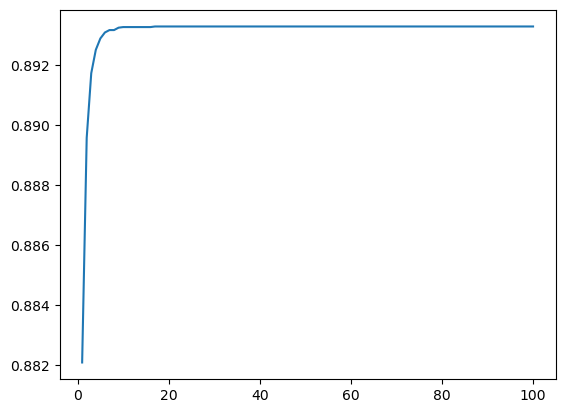

In [27]:
# Print the best configurations
print("Select the best values for each of the hyperparameters (and the best-performing initialization technique for weights) and create the optimal model. Display the test accuracy and confusion matrix for the best model.\n")
print("Best Configuration:")
print(f"Batch Size: {best_batch_size}")
print(f"Weight Initialization Technique: {best_weight_init}")
print(f"Learning Rate: {best_learning_rate}")
print(f"Regularization Coefficient (λ): {best_l2_reg}")

# Choose the best configuration
best_weights = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=best_learning_rate, l2_reg=best_l2_reg, epochs=100, batch_size=best_batch_size, weight_init=best_weight_init)

# Evaluate on the test set
y_test_pred = predict(X_test, best_weights)
test_predictions = np.argmax(y_test_pred, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)

# Display test accuracy
print(f"Test Accuracy for the Best Model: {test_accuracy:.4f}")

num_classes = y_train.shape[1] if y_train is not None else y_test.shape[1]

# Display confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions, num_classes=num_classes)
print("Confusion Matrix:")
display_confusion_matrix(conf_matrix)

Even tough the batch 1 appears to be the best batch size, let's also train for batch size 64 and compare the results, since the performance of the model for batch size 1 and batch size 64 were very similar.

Test Accuracy for the Best Model with Batch Size 64: 0.9227


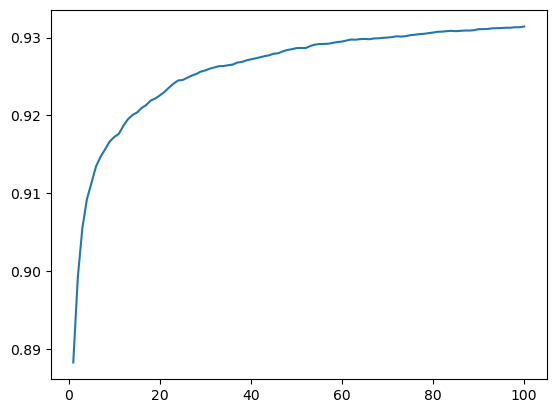

In [29]:
# For batch size 64
best_weights_64 = train_logistic_regression(X_train, y_train, X_validation, y_validation, learning_rate=best_learning_rate, l2_reg=0.01, epochs=100, batch_size=64, weight_init=best_weight_init)

# Evaluate on the test set
y_test_pred_64 = predict(X_test, best_weights_64)
test_predictions_64 = np.argmax(y_test_pred_64, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_accuracy_64 = np.sum(test_predictions_64 == test_labels) / len(test_labels)

# Display test accuracy
print(f"Test Accuracy for the Best Model with Batch Size 64: {test_accuracy_64:.4f}")

The result of the previous 64 batch test shows that the "best model" that we have found is not the actual best model since the parameters are not independent.

Visualization of the finalized weight vectors (after your best model is trained) and print them as images.


Visualization of the finalized weight vectors (after your best model is trained) and print them as images.



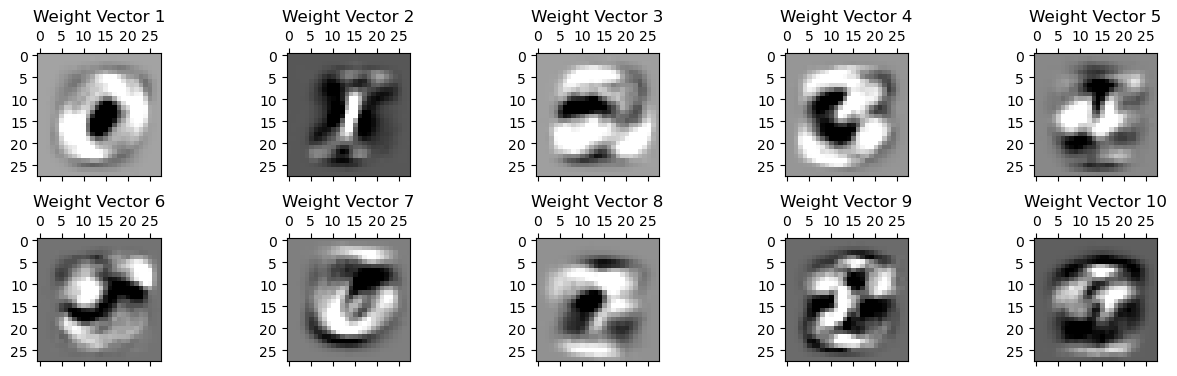

In [32]:
# Visualize weights
print("\nVisualization of the finalized weight vectors (after your best model is trained) and print them as images.\n")
fig, axes = plt.subplots(2, 5, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, ax in enumerate(axes.flat):
    weight_vector = best_weights[:, i].reshape((28, 28))
    ax.matshow(weight_vector, cmap=plt.cm.gray, vmin=0.5*weight_vector.min(), vmax=0.5*weight_vector.max())
    ax.set_title(f'Weight Vector {i+1}')

plt.show()


Using the best model, calculate precision, recall, F1 score and F2 score for each class.

In [34]:
def calculate_metrics(conf_matrix):
    metrics_per_class = []

    for i in range(len(conf_matrix)):
        true_positives = conf_matrix[i][i]
        false_positives = sum(conf_matrix[j][i] for j in range(len(conf_matrix)) if j != i)
        false_negatives = sum(conf_matrix[i][j] for j in range(len(conf_matrix)) if j != i)

        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        f2_score = (5 * precision * recall) / (4 * precision + recall) if precision + recall != 0 else 0

        metrics_per_class.append({
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'F2 Score': f2_score
        })

    return metrics_per_class

# Display metrics

metrics_per_class = calculate_metrics(conf_matrix)

for i, metrics in enumerate(metrics_per_class):
    print(f"Metrics for Class {i}:")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"F2 Score: {metrics['F2 Score']:.4f}")
    print("\n")

Metrics for Class 0:
Precision: 0.9278
Recall: 0.9837
F1 Score: 0.9549
F2 Score: 0.9720


Metrics for Class 1:
Precision: 0.9320
Recall: 0.9780
F1 Score: 0.9544
F2 Score: 0.9684


Metrics for Class 2:
Precision: 0.9381
Recall: 0.8372
F1 Score: 0.8848
F2 Score: 0.8556


Metrics for Class 3:
Precision: 0.8828
Recall: 0.8950
F1 Score: 0.8889
F2 Score: 0.8926


Metrics for Class 4:
Precision: 0.9062
Recall: 0.9053
F1 Score: 0.9058
F2 Score: 0.9055


Metrics for Class 5:
Precision: 0.8814
Recall: 0.8251
F1 Score: 0.8523
F2 Score: 0.8358


Metrics for Class 6:
Precision: 0.9240
Recall: 0.9395
F1 Score: 0.9317
F2 Score: 0.9363


Metrics for Class 7:
Precision: 0.9211
Recall: 0.8852
F1 Score: 0.9028
F2 Score: 0.8922


Metrics for Class 8:
Precision: 0.8502
Recall: 0.8450
F1 Score: 0.8476
F2 Score: 0.8460


Metrics for Class 9:
Precision: 0.8424
Recall: 0.9009
F1 Score: 0.8707
F2 Score: 0.8886


